In [23]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats

In [24]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [25]:
measurements_used = 1
energy_per_time = 1000
generate_graphs = False

In [ ]:
# exp_name = "compiler"
exp_name = "measuring_instrument"

In [26]:
used_dut_name = [
    'workstationone'
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, linux
]

used_test_case_names = [
    'fannkuch-redux.exe',
    # 'mandelbrot.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [ ]:
if exp_name == "compiler":
    experiment_name = "same-one-api-compiler-different-measuring-instruments"
    experiment_number = 1
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_mi_names = [
        ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
    ]
    
    used_compilers = [
        'intel-one-api'
    ]

used_mi_names.sort()
used_compilers.sort()

### DUTs

In [27]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [28]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod
2,3,workstationone,unix,dev
3,4,workstationone,win32nt,dev


In [29]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod


### Test Cases

In [30]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [31]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}')")

In [32]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

### Measuring Instruments

In [33]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,ipg,100
1,2,lhm,100
2,3,clamp,100
3,4,rapl,100
4,5,clamp,500
5,6,scaphandre,100
6,7,plug,100
7,8,plug,200


In [34]:
used_mi_query_list = []

if ipg in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate})")

if lhm in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

if rapl in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{rapl}' and {SAMPLE_RATE} == {rapl_sample_rate})")


if plug in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{plug}' and {SAMPLE_RATE} == {plug_sample_rate})")

if clamp in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{clamp}' and {SAMPLE_RATE} == {clamp_sample_rate})")
    
if scaphandre in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{scaphandre}' and {SAMPLE_RATE} == {scaphandre_sample_rate})")

used_mi = mi.query(" or ".join(used_mi_query_list))

### Configurations

In [35]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [36]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,0,[1]
2,3,0,200,0,"[0, 1, 2, 3]"
3,4,0,200,0,"[0, 1, 2, 3, 4, 5, 6, 7]"


In [37]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

### Experiment Names

In [38]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...
1,1,test
2,1,same-one-api-compiler-different-measuring-inst...
3,1,same-one-api-compiler-different-measuring-inst...
4,2,same-one-api-compiler-different-measuring-inst...


## Used Things

In [39]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod


In [40]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded


In [41]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100
1,2,lhm,100
2,3,clamp,100
7,8,plug,200


In [42]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded


In [43]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [44]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

for dut_index, dut_row in used_dut.iterrows():
    dut_id = dut_row[ID]
    dut_name = dut_row[NAME]
    dut_os = dut_row[OS]
    for mi_index, mi_row in used_mi.iterrows():
        mi_id = mi_row[ID]
        mi_name = mi_row[NAME]
        
        if dut_os == windows and not mi_name in windows_mi:
            continue
        
        if dut_os == linux and not mi_name in linux_mi:
            continue
        
        for config_index, config_row in used_configs.iterrows():
            config_id = config_row[ID]
            config_cores = config_row[ALLOCATED_CORES]
            if config_cores == "[]":
                config_cores = 'all'
            for tc_index, tc_row in used_tc.iterrows():
                tc_id = tc_row[ID]
                tc_name = tc_row[NAME]
                tc_compiler = tc_row[COMPILER]
                tc_language = tc_row[LANGUAGE]
                tc_optimizations = tc_row[OPTIMIZATIONS]
                tc_test_case_size = tc_row[TEST_CASE_SIZE]
                tc_threads = tc_row[THREADS]
                
                if dut_os == linux and tc_compiler == "msvc":
                    continue
                
                tc_idle_case = query.get_idle_case(used_idle_case, tc_compiler, tc_language, tc_optimizations, tc_test_case_size, tc_threads)
                tc_idle_case_id =int(tc_idle_case[ID].iloc[0])
                
                # print(f"dut {dut_name}, mi {mi_name}, config {config_id}, tc {tc_name}")
                tc_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_id, experiment_name, experiment_number)
                tc_idle_case_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_idle_case_id, experiment_name, experiment_number)
                
                tc_collection_id = int(tc_collection[ID].iloc[0])
                tc_idle_case_collection_id = int(tc_idle_case_collection[ID].iloc[0])
                
                tc_measurements = rep.get_measurements(db, tc_collection_id)
                tc_idle_case_measurements = rep.get_measurements(db, tc_idle_case_collection_id)
                
                key = f"{tc_name}.{mi_name}.{dut_name}.{config_cores}.{tc_compiler}.{dut_os}"
                
                print(key)
                
                dram_energy_results[key] = list(tc_measurements["DramEnergyInJoules"])
                cpu_energy_results[key] = list(tc_measurements["CpuEnergyInJoules"])
                gpu_energy_results[key] = list(tc_measurements["GpuEnergyInJoules"])
                duration_results[key] = list(tc_measurements["Duration"])
                
                idle_cpu_consumption = df_util.get_cpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_gpu_consumption = df_util.get_gpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_dram_consumption = df_util.get_dram_energy_per_time(tc_idle_case_measurements, energy_per_time)
                
                cpu_dynamic_energy_consumption[key] = df_util.get_cpu_dynamic_energy(tc_measurements, idle_cpu_consumption, energy_per_time)
                gpu_dynamic_energy_consumption[key] = df_util.get_gpu_dynamic_energy(tc_measurements, idle_gpu_consumption, energy_per_time)
                dram_dynamic_energy_consumption[key] = df_util.get_dram_dynamic_energy(tc_measurements, idle_dram_consumption, energy_per_time)

fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt
fannkuch-redux.exe.lhm.workstationone.all.intel-one-api.win32nt
fannkuch-redux.exe.clamp.workstationone.all.intel-one-api.win32nt
fannkuch-redux.exe.plug.workstationone.all.intel-one-api.win32nt


IndexError: single positional indexer is out-of-bounds

In [ ]:
config_cores == "[]"

False

In [ ]:
for key, value in dram_energy_results.items():
    dram_energy_results[key] = value[:measurements_used]
    
for key, value in cpu_energy_results.items():
    cpu_energy_results[key] = value[:measurements_used]

for key, value in gpu_energy_results.items():
    gpu_energy_results[key] = value[:measurements_used]

for key, value in duration_results.items():
    duration_results[key] = value[:measurements_used]
    
for key, value in cpu_dynamic_energy_consumption.items():
    cpu_dynamic_energy_consumption[key] = value[:measurements_used]

for key, value in gpu_dynamic_energy_consumption.items():
    gpu_dynamic_energy_consumption[key] = value[:measurements_used]
    
for key, value in dram_dynamic_energy_consumption.items():
    dram_dynamic_energy_consumption[key] = value[:measurements_used]

In [ ]:
## Energy consumption for the entire test case
dram_df = pd.DataFrame(dram_energy_results)
dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

cpu_df = pd.DataFrame(cpu_energy_results)
cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

gpu_df = pd.DataFrame(gpu_energy_results)
gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

duration_df = pd.DataFrame(duration_results)
duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

## Dynamic energy data frames
dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

In [ ]:
for column in duration_df.columns:
    duration_df[column] = duration_df[column] / 1000

In [ ]:
duration_df

,fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt,fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt
0,30.552,17.340,32.116,44.729
1,29.533,20.369,34.531,48.935
2,28.516,19.145,32.526,44.205
3,29.687,18.416,41.820,46.493
4,31.166,19.499,32.319,44.892
...,...,...,...,...
545,30.554,20.567,32.381,41.775
546,32.735,18.402,33.054,50.374
547,30.899,19.823,33.270,41.817
548,32.013,18.882,32.641,45.525


In [ ]:
dram_df

,fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt,fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt
0,17.944031,10.169495,18.789490,26.166260
1,17.308655,11.929871,20.141174,28.621399
2,16.729980,11.209534,19.089355,25.871704
3,17.570190,10.774048,24.487671,27.396301
4,18.302307,11.413147,18.918091,26.288269
...,...,...,...,...
545,17.857361,12.014343,19.053711,24.392212
546,19.120361,11.093689,19.293640,29.464233
547,15.174438,11.577271,19.409790,24.431824
548,18.680054,11.022156,19.220215,26.589172


Combined DRAM Energy Consumption in Joules


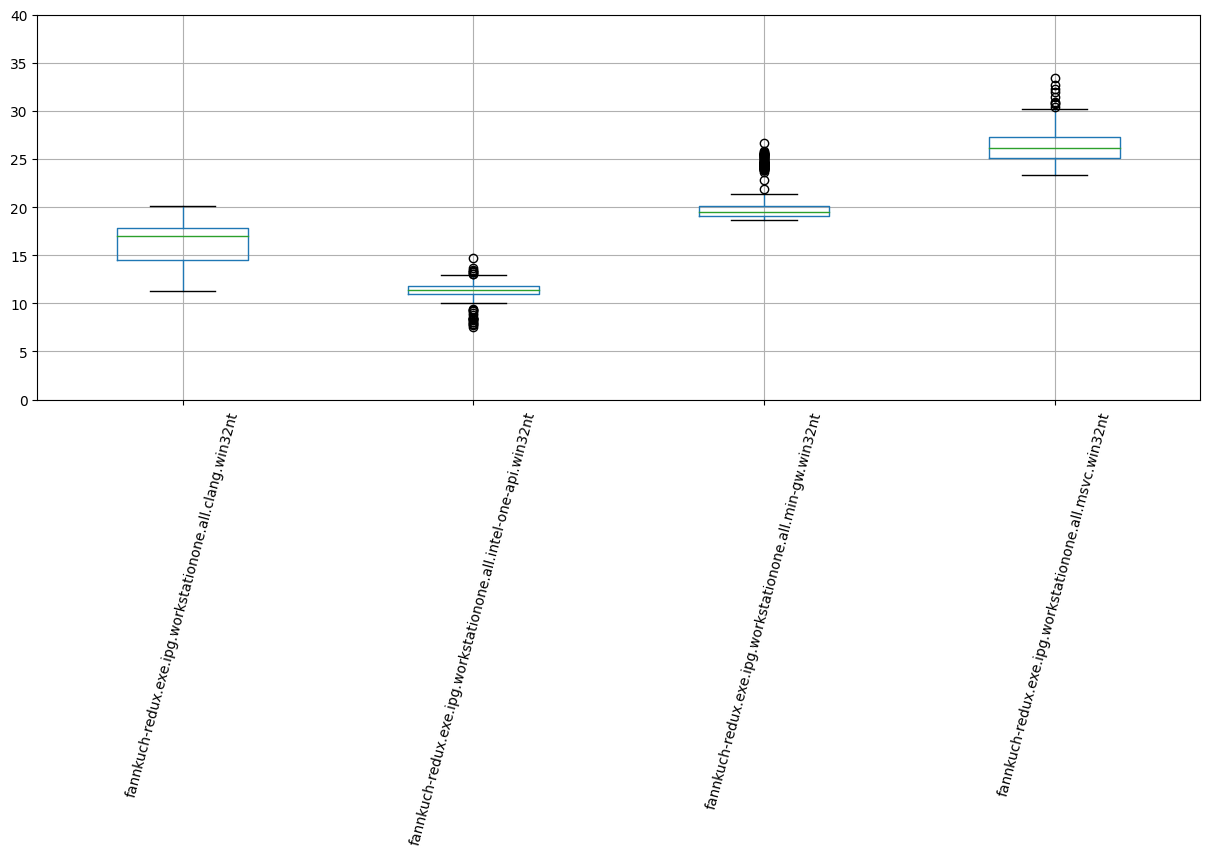

Combined CPU Energy Consumption in Joules


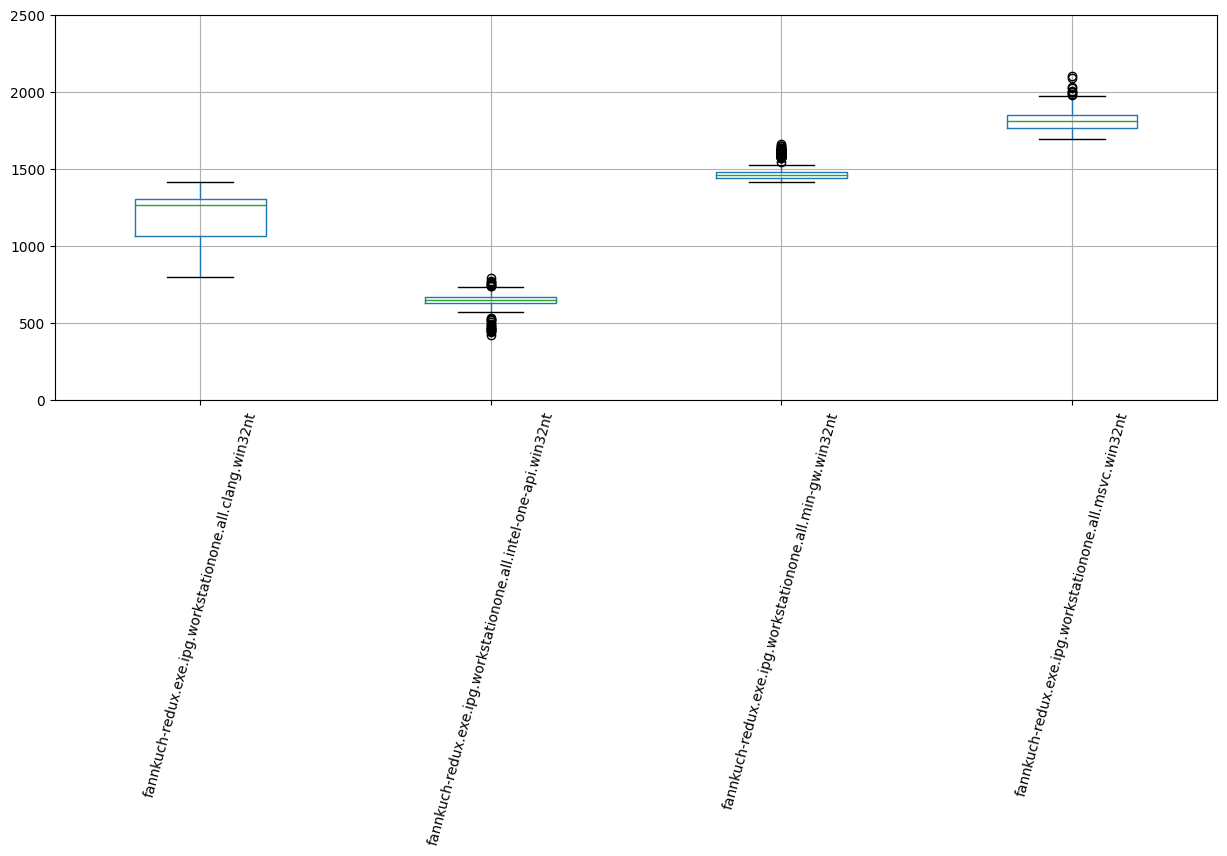

Combined GPU Energy Consumption in Joules


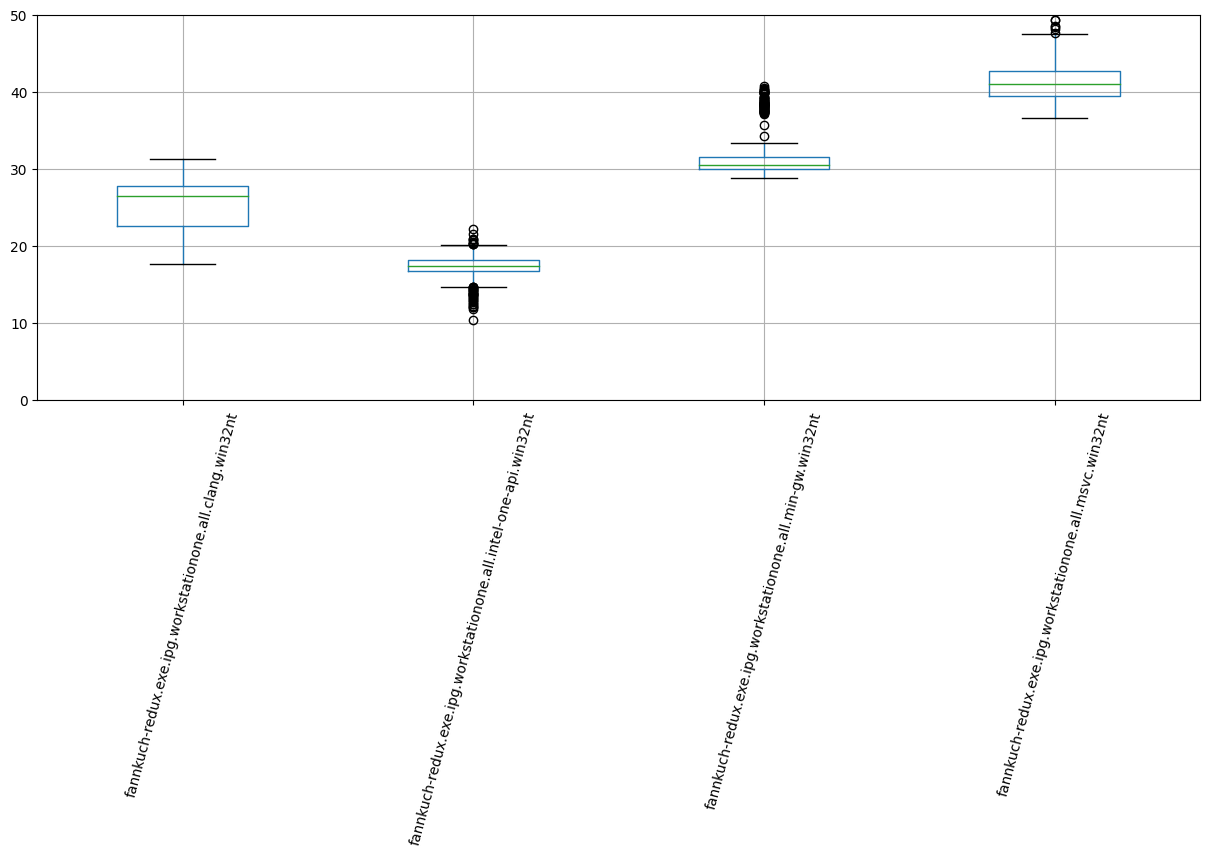

Duration of Test Case


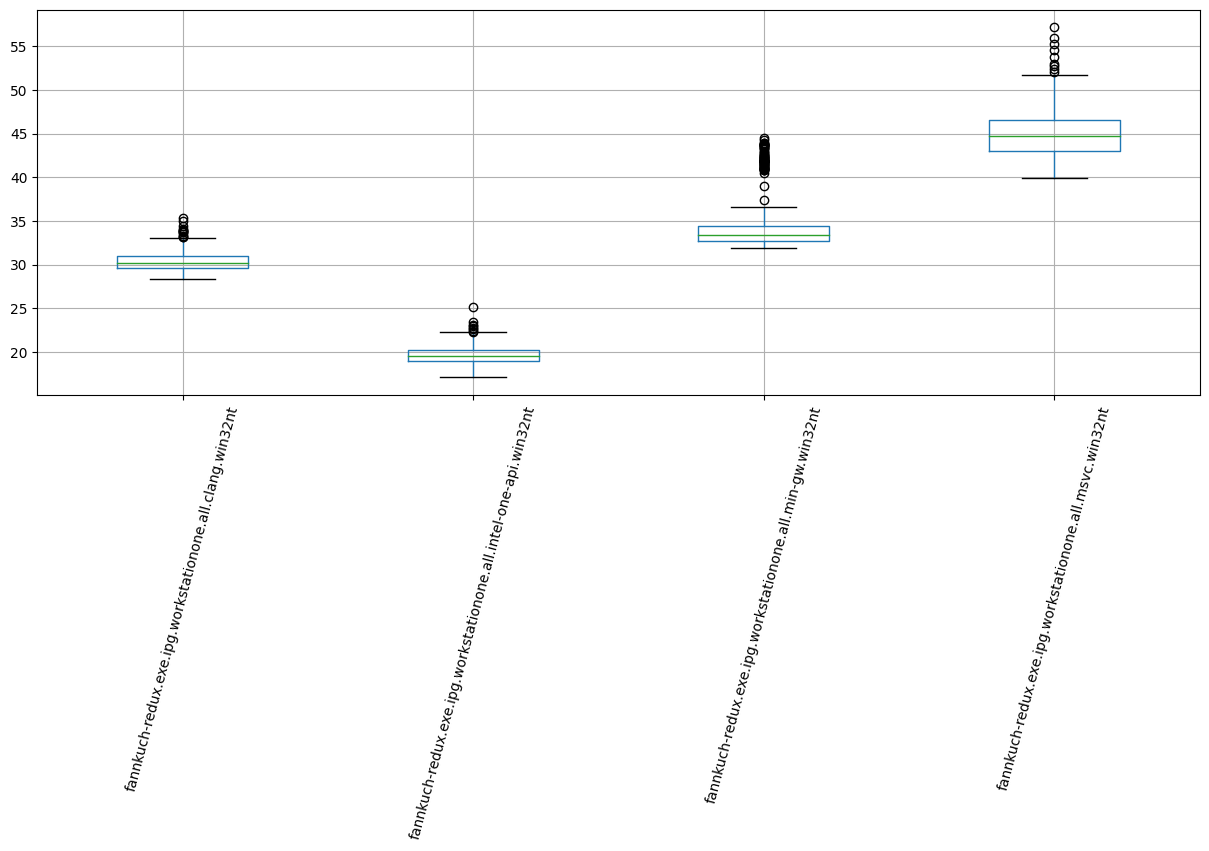

In [ ]:
print("Combined DRAM Energy Consumption in Joules")
dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=75)
dram_boxplot.plot()
plot.ylim(0, 40)
plot.show()

print("Combined CPU Energy Consumption in Joules")
cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=75)
cpu_boxplot.plot()
cpu_boxplot
plot.ylim(0,2500)
plot.show()

print("Combined GPU Energy Consumption in Joules")
gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=75)
gpu_boxplot.plot()
plot.ylim(0,50)
plot.show()

print("Duration of Test Case")
duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=75)
duration_boxplot.plot()
# plot.ylim(0,40)
plot.show()

Dynamic DRAM Energy Consumption in Watts


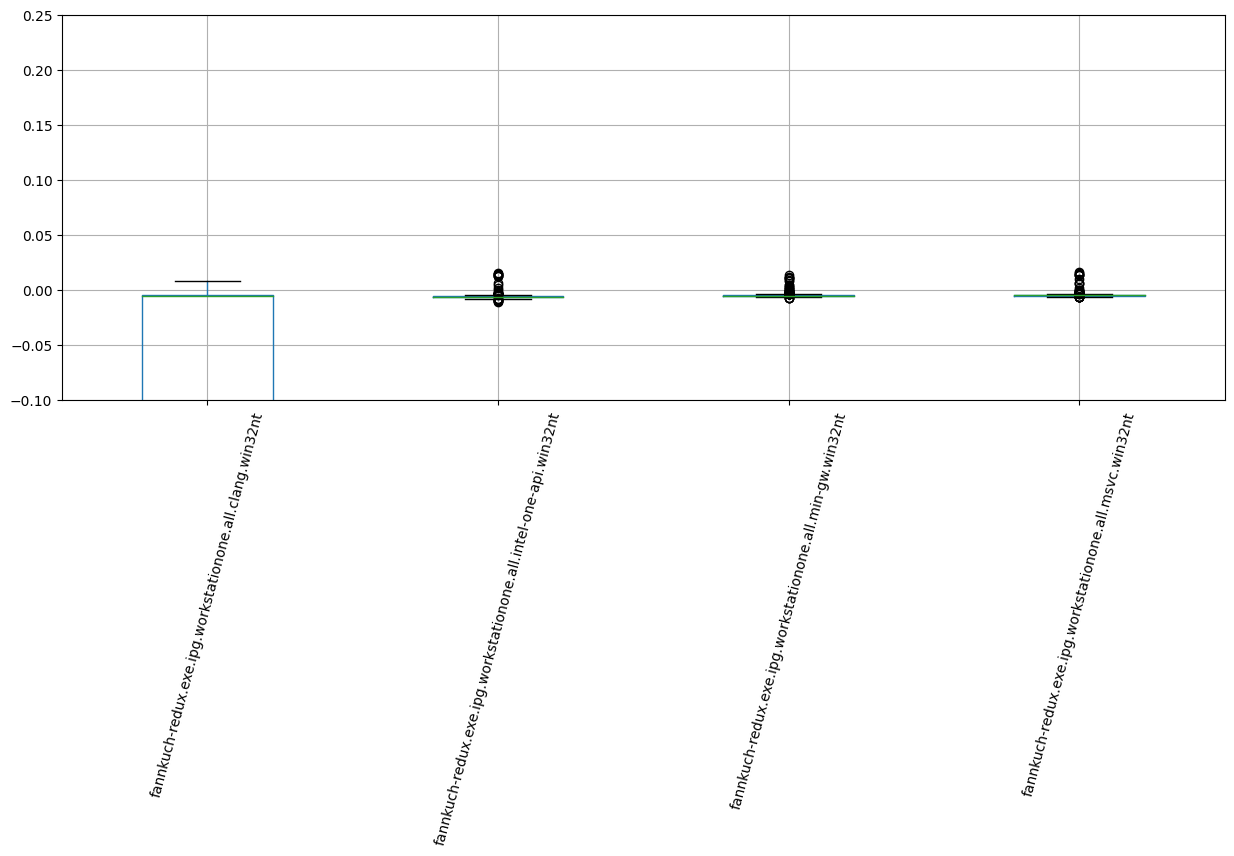

Dynamic CPU Energy Consumption in Watts


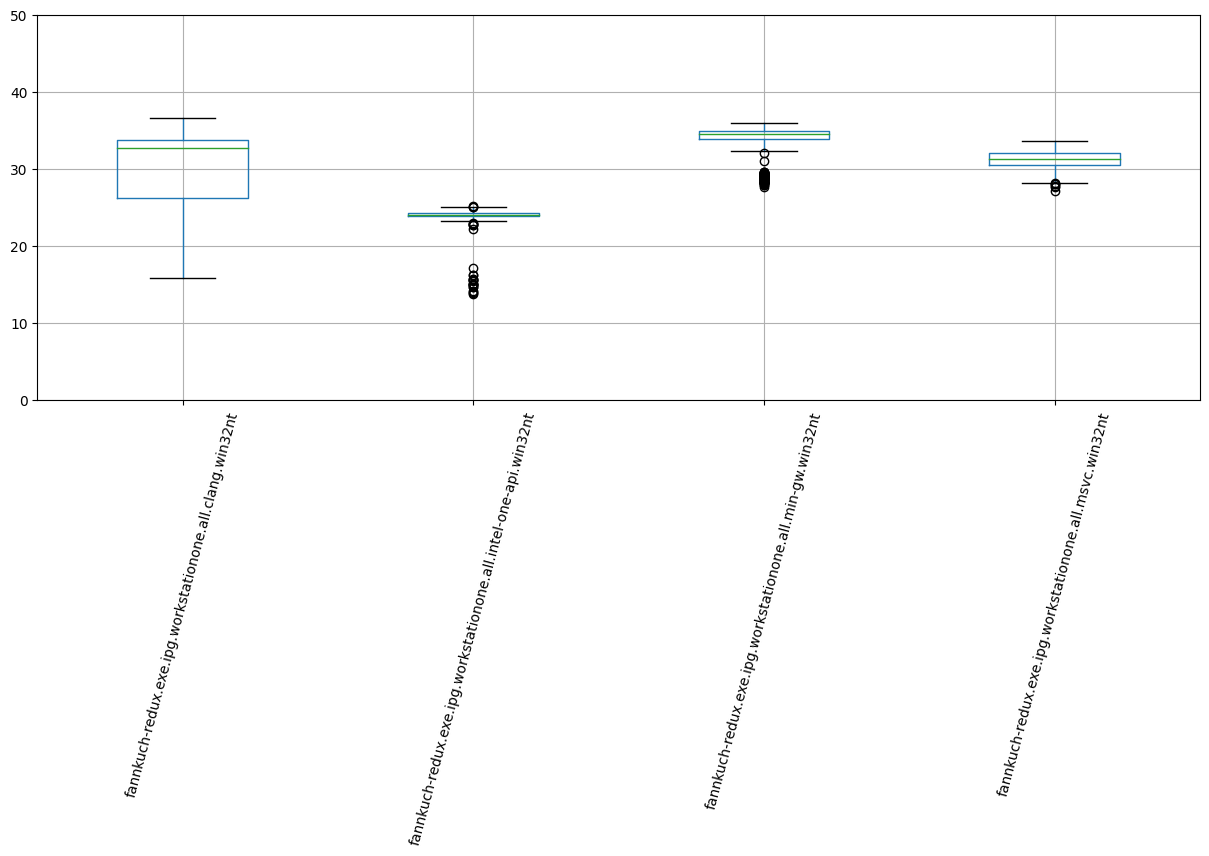

Dynamic GPU Energy Consumption in Watts


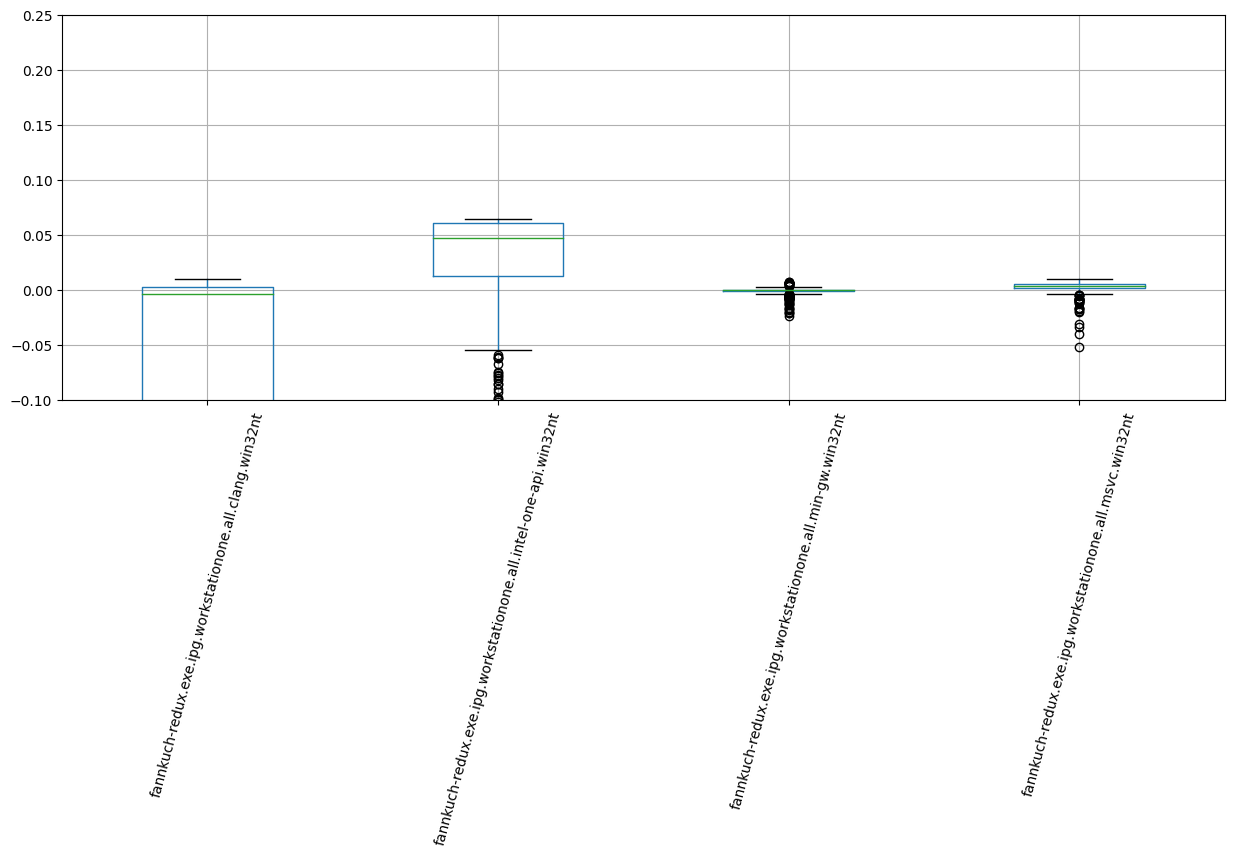

In [ ]:
print("Dynamic DRAM Energy Consumption in Watts")
dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=75)
dynamic_dram_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()

print("Dynamic CPU Energy Consumption in Watts")
dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
dynamic_cpu_boxplot.plot()
plot.ylim(0,50)
plot.show()

print("Dynamic GPU Energy Consumption in Watts")
dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
dynamic_gpu_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()


In [ ]:
cpu_dynamic_df

,fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt,fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt
0,34.567827,24.583273,35.621682,31.733293
1,35.625896,24.571549,34.376753,31.117817
2,36.522181,24.518630,35.376826,32.422056
3,36.157709,24.190246,28.889563,30.777198
4,34.433066,24.766111,35.718227,31.638281
...,...,...,...,...
545,33.255280,23.374486,35.125949,32.962681
546,32.667606,24.309581,35.006862,28.933381
547,26.252826,23.818569,34.420687,32.734946
548,32.627918,23.862976,35.242069,30.717704


In [ ]:
def list_to_label(lst):
    if len(lst) == 1:
        return lst[0]
    elif len(lst) == 2:
        return f"{lst[0]} and {lst[1]}"
    else:
        return ", ".join(lst[:-1]) + f" and {lst[-1]}"

def get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler):
    caption = f"{name} measurements"

    if not ',' in c_measuring_instrument:
        caption += f" by {c_measuring_instrument}"

    if not ',' in c_duts:
        caption += f" on {c_duts}"
        
    if not ',' in c_test_cases:
        caption += f" for test case(s) {c_test_cases}"
        
    if not ',' in c_compiler:
        caption += f" compiled on {c_compiler}"

    return caption

In [ ]:
box_plot_raw_data = [
    {
        "data" : cpu_dynamic_df,
        "name" : "cpu",
        "data_type" : "dynamic energy consumption",
        "width" : 0.45,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "Average Energy Consumption (Watt)"
    },
    {
        "data" : cpu_df,
        "name" : "cpu",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 2000,
        "xlabel" : "Total Energy Consumption (Joules)"
    },
    {
        "data" : dram_dynamic_df,
        "name" : "dram",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : -0.1,
        "xmax" : 0.1,
        "xlabel" : "Average Energy Consumption (Watt)"
    },
    {
        "data" : dram_df,
        "name" : "dram",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "Total Energy Consumption (Joules)"
    },
    {
        "data" : gpu_dynamic_df,
        "name" : "gpu",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : -0.1,
        "xmax" : 0.1,
        "xlabel" : "Average Energy Consumption (Watt)"
    },
    {
        "data" : gpu_df,
        "name" : "gpu",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Total Energy Consumption (Watt)"
    },
    {
        "data" : duration_df,
        "name" : "runtime",
        "data_type" : "duration",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Average Runtime (s)"
    }
]

In [ ]:
if generate_graphs:
    for plot_data in box_plot_raw_data:
        data = plot_data["data"]
        name = plot_data["name"]
        data_type = plot_data["data_type"]
        width = plot_data["width"]
        height = 0.1 + (len(data.columns) * 0.02)
        xmin = plot_data["xmin"]
        xmax = plot_data["xmax"]
        xlabel = plot_data["xlabel"]
        
        latex_boxes = tex.get_boxes(data)
        
        title = f"The {data_type} of the {name}"
        
        ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
        
        yticklables = tex.get_ytick_labels(data, used_test_case_names, used_mi_names, used_dut_name, used_allocated_cores, used_compiler_str, used_os_names)
        
        labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}-{name.replace(' ', '_')}-{data_type.replace(' ', '_')}"
        
        c_test_cases = list_to_label(used_test_case_names)
        c_compiler = list_to_label(used_compilers)
        c_duts = list_to_label(used_dut_name)
        c_measuring_instrument = list_to_label(used_mi_names)
        
        c_test_cases = c_test_cases.replace(".exe", "")
        
        caption = get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler)
        
        latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

        box_plot_path = f"{experiment_number}/{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
        box_plot_file_name = f"{name}_{data_type.replace(' ', '_')}.tex"
        print(f"generating {box_plot_file_name}")
        path_util.write_to_path(box_plot_path, box_plot_file_name, latex_box_plot)
else:
    print("generating plots is disabled")

generating cpu_dynamic_energy_consumption.tex
generating cpu_energy_consumption.tex
generating dram_dynamic_energy_consumption.tex
generating dram_energy_consumption.tex
generating gpu_dynamic_energy_consumption.tex
generating gpu_energy_consumption.tex
generating runtime_duration.tex


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth,
            height=WIDHT\textheight
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK},
        yticklabels={
            LABELS
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES};
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```

In [ ]:
caption = f"{data_type} measurementson the {name}"

if not ',' in c_measuring_instrument:
    caption += f", measured by {c_measuring_instrument}"

if not ',' in c_duts:
    caption += f" on {c_duts}"
    
if not ',' in c_test_cases:
    caption += f", for test cases {c_test_cases}"
    
if not ',' in c_compiler:
    caption += f", compiled on {c_compiler}"

caption

'duration measurementson the runtime, measured by ipg on workstationone, for test cases fannkuch-redux'

In [ ]:
cpu_dynamic_df

,fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt,fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt
0,34.567827,24.583273,35.621682,31.733293
1,35.625896,24.571549,34.376753,31.117817
2,36.522181,24.518630,35.376826,32.422056
3,36.157709,24.190246,28.889563,30.777198
4,34.433066,24.766111,35.718227,31.638281
...,...,...,...,...
545,33.255280,23.374486,35.125949,32.962681
546,32.667606,24.309581,35.006862,28.933381
547,26.252826,23.818569,34.420687,32.734946
548,32.627918,23.862976,35.242069,30.717704


In [ ]:
Z = 1.96
E = 0.03

# Z = 2.58
# E = 0.01

include_outliers = False

used_df = cpu_dynamic_df

for column in used_df.columns:
    used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
    
    values = used_df_without_outlisers
    n_zero_without = math_util.get_cochran(values, Z, E)
    
    values = list(used_df[column])
    n_zero = math_util.get_cochran(values, Z, E)
    
    print(f"{column} - with outliers: {n_zero}, without outliers: {n_zero_without}")

fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt - with outliers: 73997.81524820626, without outliers: 73997.81524820626
fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt - with outliers: 12059.864185347207, without outliers: 498.4636828980579
fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt - with outliers: 16263.164618006504, without outliers: 1548.9455792960657
fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt - with outliers: 5505.823874360503, without outliers: 4999.329868364829


fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt


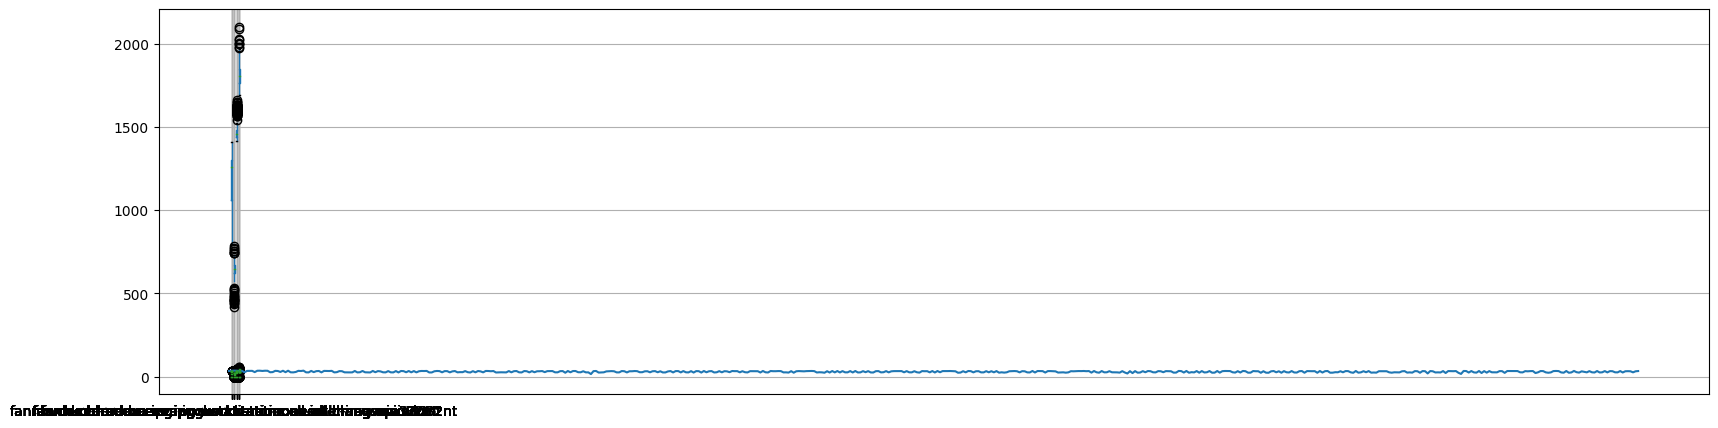

fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt


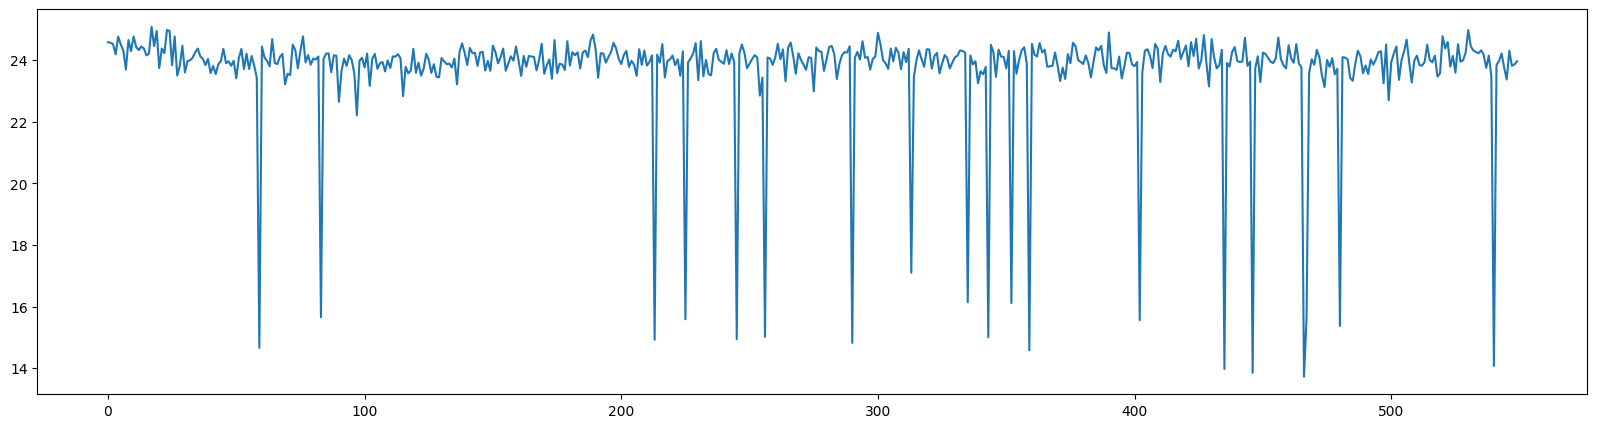

fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt


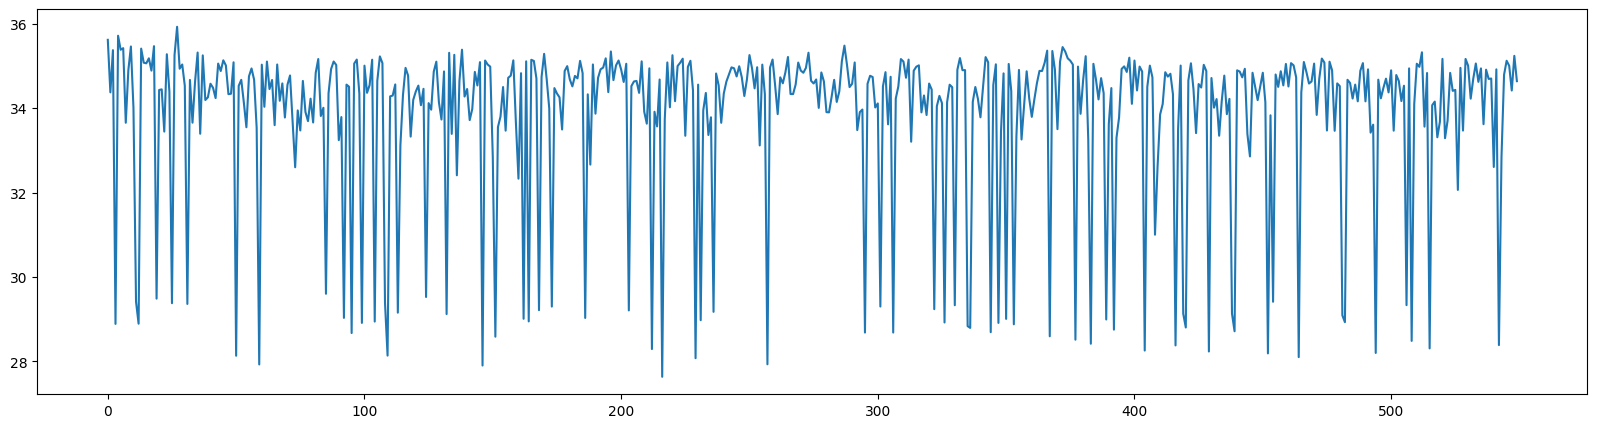

fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt


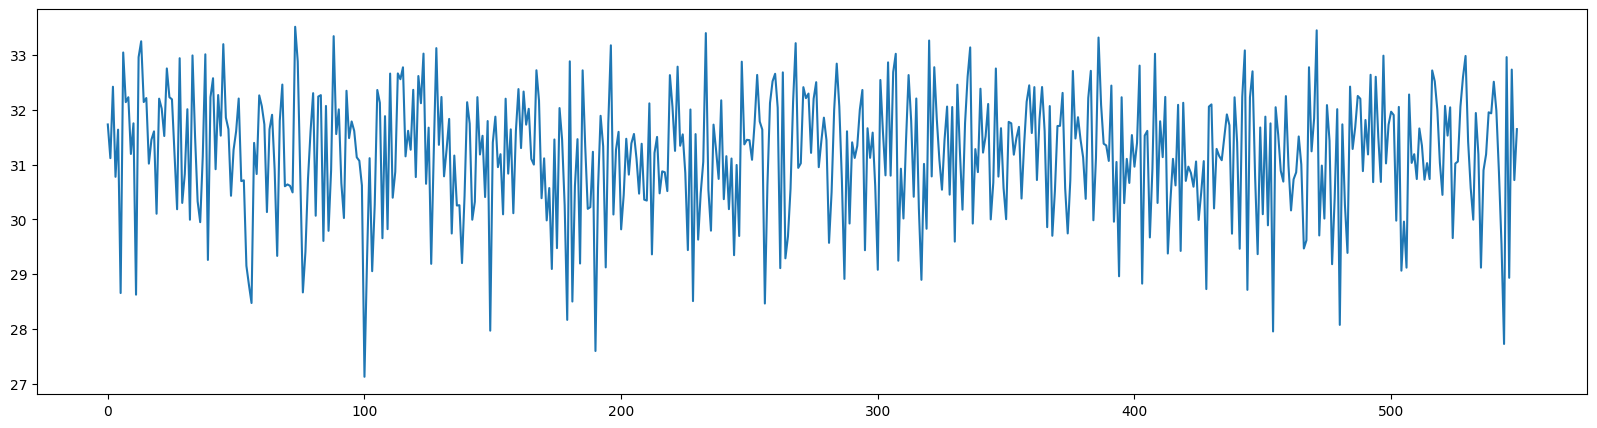

In [ ]:

for column in used_df.columns:
    print(column)
    plot.rcParams["figure.figsize"] = (20,5)
    plot.plot(list(used_df[column]))
    plot.show()

